# Principal Component Analysis (PCA) and Clustering

We will group our gym members into clusters. The idea is to use these clusters to place gym members into groups of customers that exhibit similar behaviors. This will help us identify the patterns that influence whether customer decides to stay or leave.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [2]:
df = pd.read_csv('gym_churn_us.csv')

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# normalize data
scaler = RobustScaler()
X_norm = scaler.fit_transform(X_train)

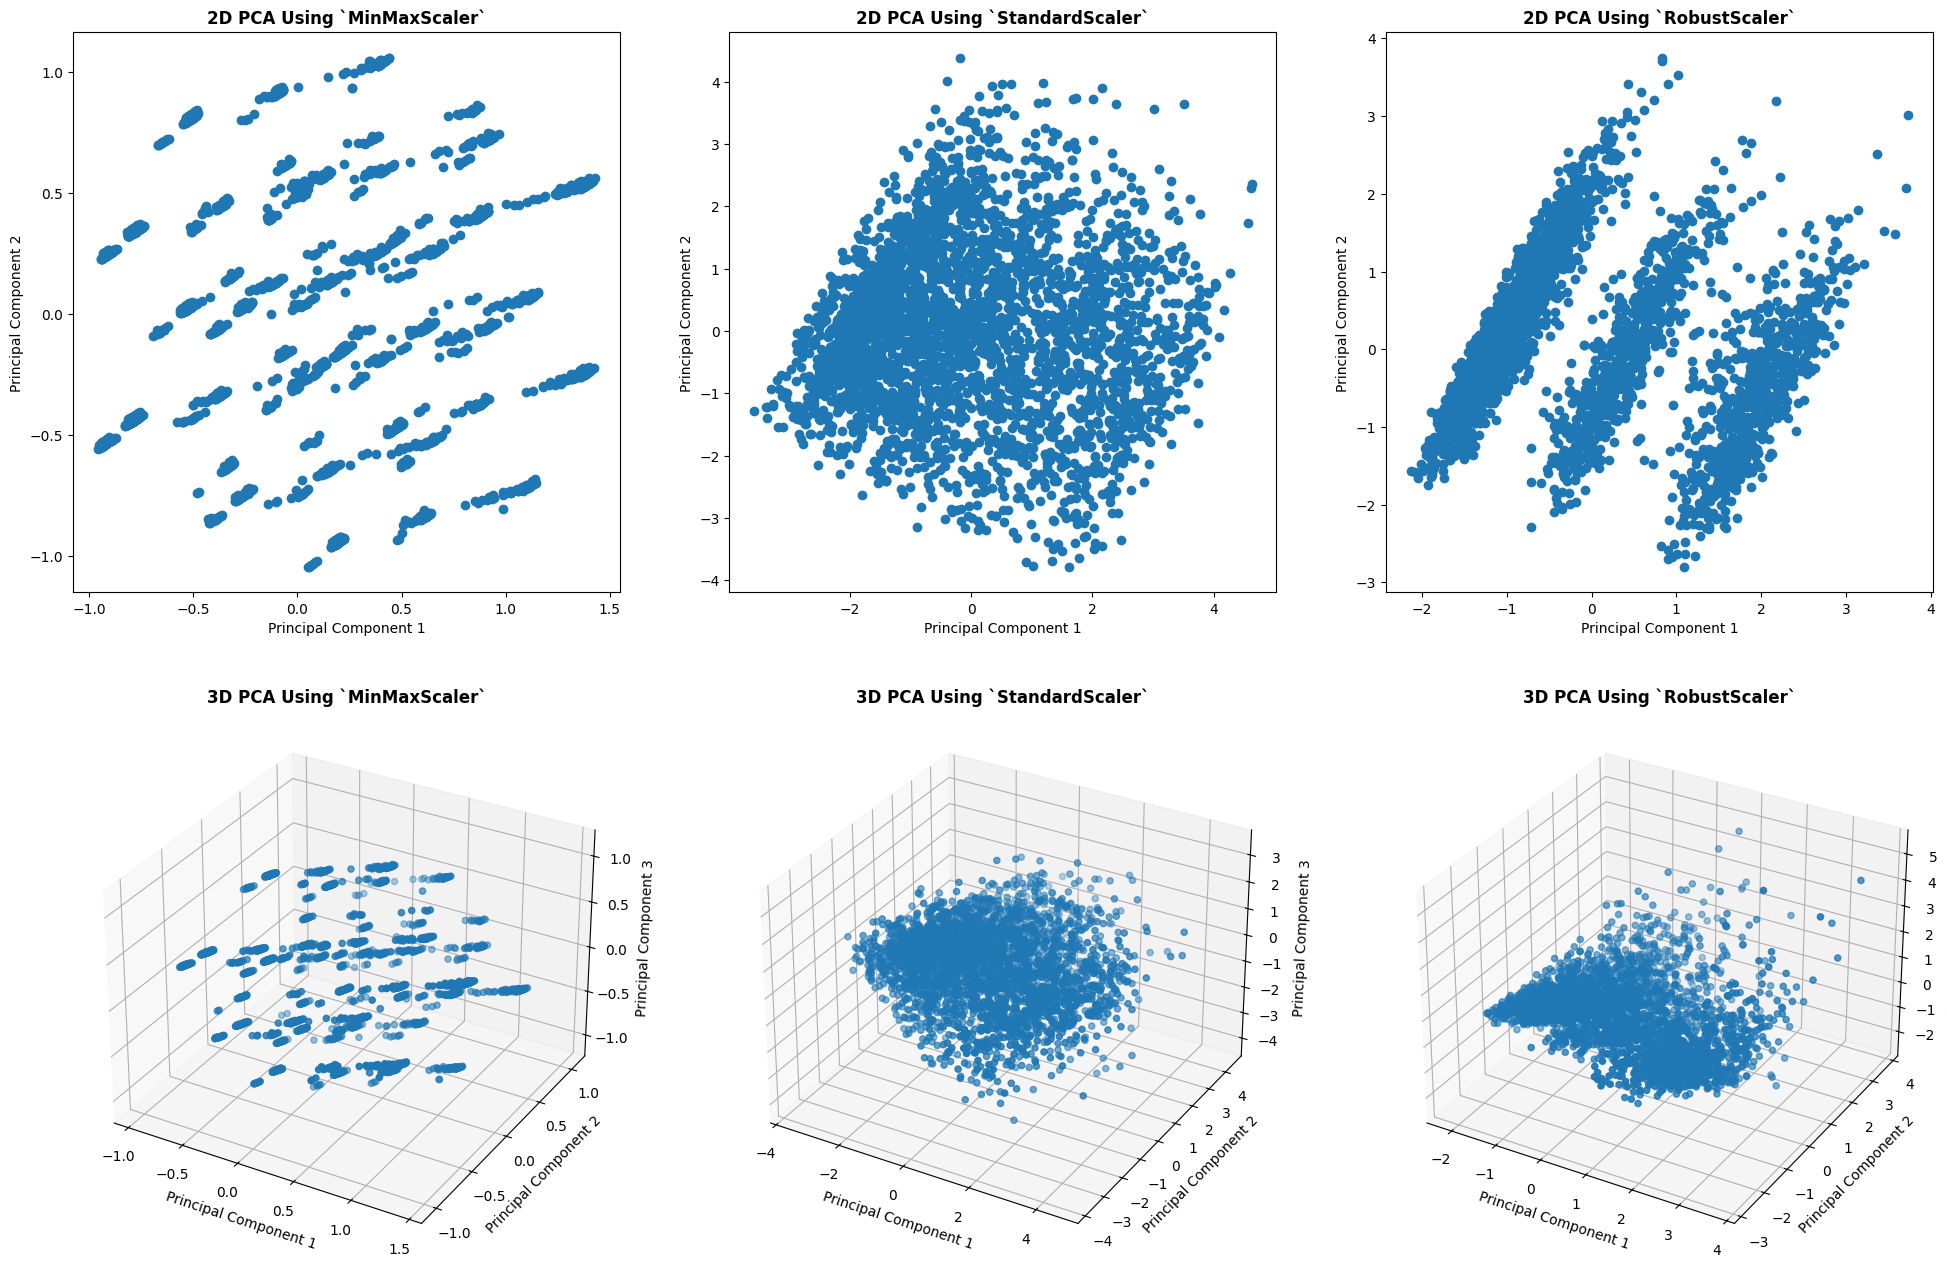

In [3]:
scalers = {'`MinMaxScaler`': MinMaxScaler(),
           '`StandardScaler`': StandardScaler(),
           '`RobustScaler`': RobustScaler()}


fig = plt.figure(figsize=(24,16))

for i, (key, value) in enumerate(scalers.items()):
    for n_components in range(2,4):
        scaler_name = key
        scaler = value

        projection = '3d' if n_components==3 else None
        ax = fig.add_subplot(2,3,(i+1)+(n_components-2)*3, projection=projection)

        X_norm = scaler.fit_transform(X_train)

        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_norm)
        ax.scatter(*X_pca.T)
        
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        if n_components == 3:
            ax.set_zlabel('Principal Component 3')
        
        ax.set_title(f'{n_components}D PCA Using {scaler_name}', fontweight='bold')

plt.show()

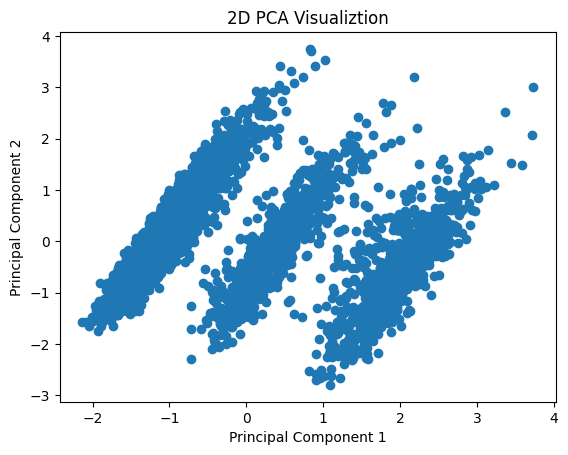

In [4]:
# perform PCA to reduce dimensionality of data for visualizations
n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_norm)
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.title('2D PCA Visualiztion')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [5]:
# Fit GMM with 3 components
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
labels = gmm.fit_predict(X_pca)  # X_pca: shape (n, 2)

# probabilities for soft clustering
probs = gmm.predict_proba(X_pca)

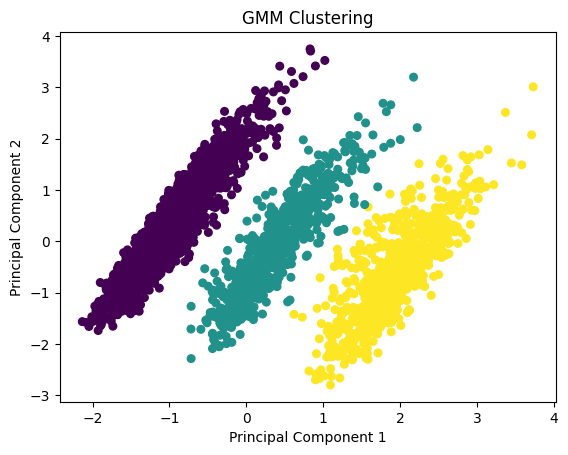

In [6]:
# plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=30)
plt.title("GMM Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()